<img src="https://www.iscte-iul.pt/assets/images/logo_iscte_detailed.svg" style="width: 450px;margin-top:30px;" align ="center">

<div style= "font-size: 40px;  margin-top:40px; font-weight:bold; font-family: 'Avenir Next LT Pro', sans-serif;"><center>Part 2: <strong>Classical Modeling</strong></center></div>
<div style= "font-size: 40px; font-weight:bold; font-family: 'Avenir Next LT Pro', sans-serif;"><center>of time series</center></div>

<div style= "font-size: 27px;font-weight:bold;line-height: 1.1; margin-top:40px; font-family: 'Avenir Next LT Pro', sans-serif;"><center>Análise de Séries Temporais e Previsão 2024/2025</center></div> <br>

   <div style= "font-size: 20px;font-weight:bold; font-family: 'Avenir Next LT Pro', sans-serif;"><center> Grupo 7:</center></div>
   <div><center> Diogo Freitas | 104841 </center></div>
   <div><center> João Francisco Botas | 104782 </center></div>
   <div><center> Miguel Gonçalves | 105944 </center></div>
   <div><center> Ricardo Galvão | 105285 </center></div>

Importação dos pacotes necessários

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
from fredapi import Fred
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from collections import OrderedDict
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import adfuller, kpss, bds
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import skewtest, kurtosistest, skew, kurtosis, boxcox
from pathlib import Path
import os
os.environ['OMP_NUM_THREADS'] = '1'

In [4]:
import optuna

Criação/carregamento do ficheiro de armazenamento de corridas de optuna

In [5]:
optuna_storage_path = "optuna_journal_storage.log"
lock_obj = optuna.storages.journal.JournalFileOpenLock(optuna_storage_path)
storage = optuna.storages.JournalStorage(
    optuna.storages.journal.JournalFileBackend(optuna_storage_path, lock_obj=lock_obj)
)

In [6]:
import logging
cmdstanpy_logger = logging.getLogger("cmdstanpy")
cmdstanpy_logger.disabled = True

# Importação do **darts**

O darts é uma biblioteca de python para timeseries, com o intuito de simplificar e agilizar o processo de análise e modelação de séries temporais.

In [7]:
from darts import TimeSeries
from darts.utils import statistics
from darts.metrics import mape, smape, r2_score
from darts.utils.utils import ModelMode, SeasonalityMode

Para aceder a séries temporais do FRED (fred.stlouisfed.org) ao vivo, utilizamos uma API Key pessoal.

In [8]:
fred = Fred(api_key="8ede227d95e33c5cdf2ea8a83577bc0a")

Séries temporais escolhidas:

In [9]:
fred_series_ids = ["IHLIDXNSAGB", "IRLTLT01GBM156N", "QGBN628BIS", "UKNGDP", "GBRCPIALLMINMEI"]

In [10]:
fred_series_metadata = []
fred_series_list = []
for series in fred_series_ids:
    metadata = fred.get_series_info(series)
    series = fred.get_series(series).rename(metadata["title"])
    fred_series_metadata.append(metadata)
    fred_series_list.append(series)

Dados extra: Incerteza com políticas económicas no Reino Unido com periodicidade diária não existe no FRED

In [11]:
economic_uncertainty = pd.read_csv("../data/UK_Daily_Policy_Data.csv")

In [12]:
economic_uncertainty["date"] = pd.to_datetime(economic_uncertainty.drop("daily_policy_index", axis=1))
economic_uncertainty = economic_uncertainty.drop(["day", "month", "year"], axis=1).set_index("date").squeeze()

In [13]:
economic_uncertainty

date
2001-01-01     50.70
2001-01-02    110.77
2001-01-03    179.41
2001-01-04    183.22
2001-01-05     89.31
               ...  
2025-04-26    287.84
2025-04-27    340.04
2025-04-28    418.48
2025-04-29    255.07
2025-04-30    367.90
Name: daily_policy_index, Length: 8886, dtype: float64

In [14]:
data = fred_series_list.copy()
data.append(economic_uncertainty)

In [15]:
# Conversão para formato time series suportado pelo darts
data_ts = [TimeSeries.from_series(series) for series in data]

In [16]:
# Teste de sazonalidade 
[statistics.check_seasonality(series, max_lag=365) for series in data_ts]

[(False, 0), (False, 0), (False, 0), (False, 0), (False, 0), (True, 7)]

# Time Series Forecasting

In [17]:
[print(str(idx) + " " + series.title) for idx, series in enumerate(fred_series_metadata)]
print(str(len(data_ts) - 1) + " " + "UK_Daily_Policy_Data")

0 Job Postings on Indeed in the United Kingdom
1 Interest Rates: Long-Term Government Bond Yields: 10-Year: Main (Including Benchmark) for United Kingdom
2 Residential Property Prices for United Kingdom
3 Gross Domestic Product for United Kingdom
4 Consumer Price Indices (CPIs, HICPs), COICOP 1999: Consumer Price Index: Total for United Kingdom
5 UK_Daily_Policy_Data


In [18]:
series_names = ["Job_Postings", "Interest_Rates", "Residential_Property_Prices", 
                "GDP", "CPI", "Economic_Uncertainty"]

#### **Escolher série temporal para modelar**

Para este trabalho, focamos a série "Job Postings on Indeed".

In [19]:
series_chosen_id = 1

In [20]:
series = data_ts[series_chosen_id]
series_name = series_names[series_chosen_id]

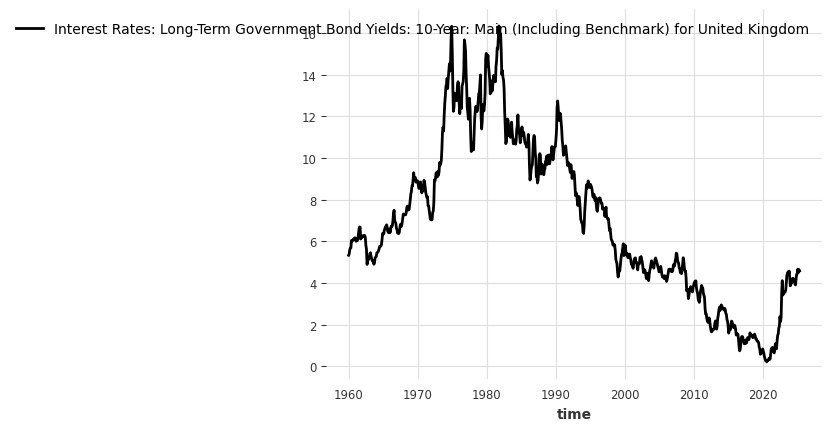

In [21]:
series.plot()
plt.show()

splitting: proporção da série usar para treino de modelos, o resto é usado para teste 
1 - visualizing: proporção da série que queremos visualizar

In [22]:
splitting = 0.9
visualizing = 0.7

In [23]:
train, test = series.split_before(splitting)

## Primeiro modelo - Alisamento exponencial

No pacote **darts**, a família de modelos de Exponential Smoothing utiliza os parâmetros _trend_  e _seasonal_ para especificar o modelo.

In [24]:
from darts.models import ExponentialSmoothing

model = ExponentialSmoothing(trend=ModelMode.ADDITIVE, 
                             seasonal=SeasonalityMode.ADDITIVE)
model.fit(train)
prediction = model.predict(len(test))

In [25]:
model.model_params

OrderedDict([('trend', <ModelMode.ADDITIVE: 'additive'>),
             ('damped', False),
             ('seasonal', <SeasonalityMode.ADDITIVE: 'additive'>),
             ('seasonal_periods', None),
             ('random_state', 0),
             ('kwargs', None)])

In [26]:
model.seasonal_periods

12

Análise de resíduos:

In [27]:
residuals = model.residuals(train, verbose=True)

historical forecasts:   0%|          | 0/680 [00:00<?, ?it/s]

In [28]:
print(residuals.mean(axis=0).values())
print(np.std(residuals.to_series()))

[[-0.02458105]]
0.3429597528820141


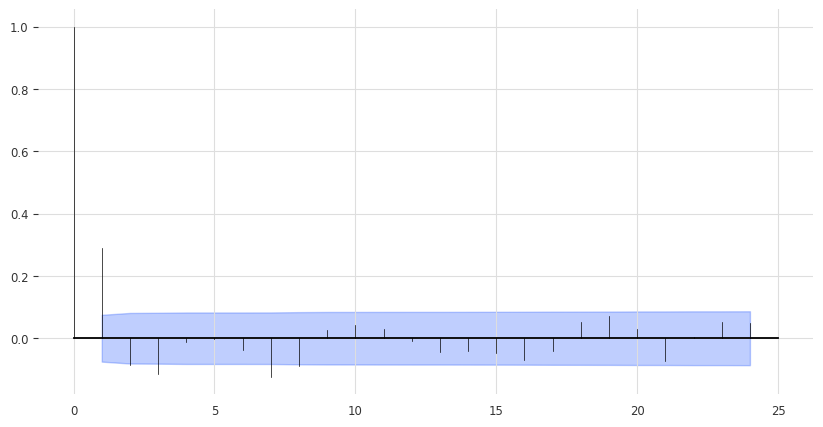

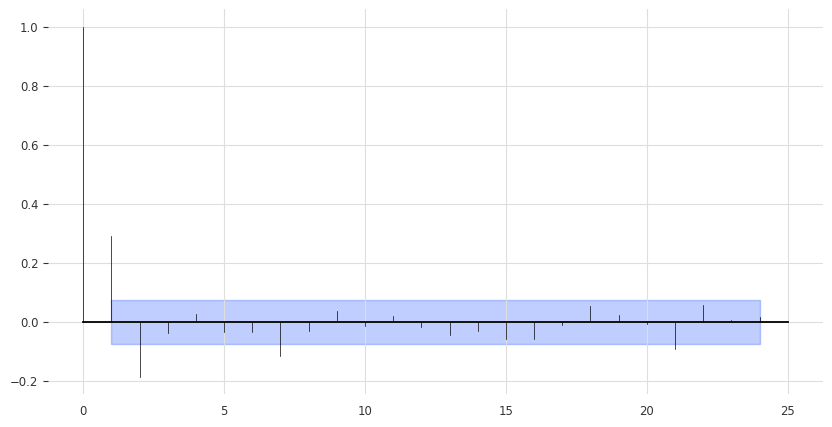

In [29]:
statistics.plot_acf(residuals)
plt.show()
statistics.plot_pacf(residuals)
plt.show()

Ainda se verifica alguma autocorrelação na análise dos resíduos.

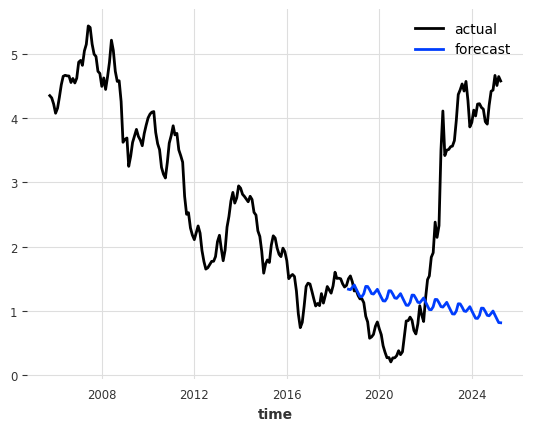

In [30]:
series.drop_before(visualizing).plot(label="actual")  # plot only last 1-visualizing of series
prediction.plot(label="forecast", low_quantile=0.05, high_quantile=0.95)
plt.legend()
plt.show()

## Segundo modelo - Família ARIMA

Neste segmento exploramos a seleção de modelos automática providenciada pelo **darts/statsforecast**.  


Critério selecionado: "BIC"

In [31]:
from darts.models import AutoARIMA

print(f"Information Criteria: {(ic:='bic')}")
model_aarima = AutoARIMA(trace=True, ic=ic, seasonal=True)
model_aarima = model_aarima.fit(train)
prediction_aarima = model_aarima.predict(len(test))

Information Criteria: bic

ARIMA(2,1,2) with drift        :366.23875846274626

ARIMA(0,1,0) with drift        :441.5114017119695

ARIMA(1,1,0) with drift        :369.0406599164327

ARIMA(0,1,1) with drift        :354.2854032415081

ARIMA(0,1,0)                   :435.1601178269001

ARIMA(1,1,1) with drift        :360.55753405322747

ARIMA(0,1,2) with drift        :360.3756369902082

ARIMA(1,1,2) with drift        :363.9505147324274

ARIMA(0,1,1)                   :347.85326188975955

ARIMA(1,1,1)                   :354.1205804413995

ARIMA(0,1,2)                   :353.9361158017699

ARIMA(1,1,0)                   :362.5863778707603

ARIMA(1,1,2)                   :357.5091001065179
Now re-fitting the best model(s) without approximations...


ARIMA(0,1,1)                   :347.85326188975955


phi = p  
theta = q   
delta = d  

Vemos evidências de um comportamento peculiar das previsões a longo prazo de modelos ARIMA.

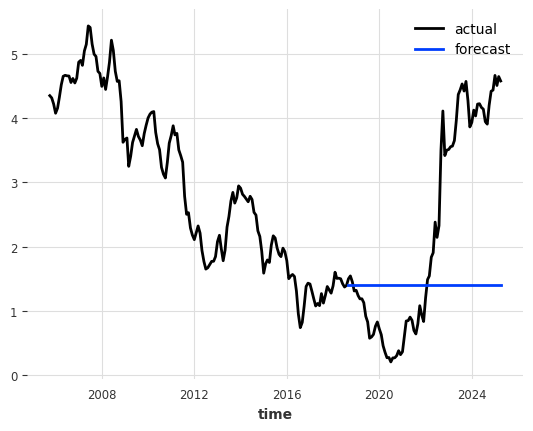

In [32]:
series.drop_before(visualizing).plot(label="actual")  # plot only last 5% of series
prediction_aarima.plot(label="forecast", low_quantile=0.05, high_quantile=0.95)
plt.legend()
plt.show()

Os modelos ARIMA, quando projetados para um futuro acima da ordem da componente de média móvel, as previsões alinham-se numa reta.

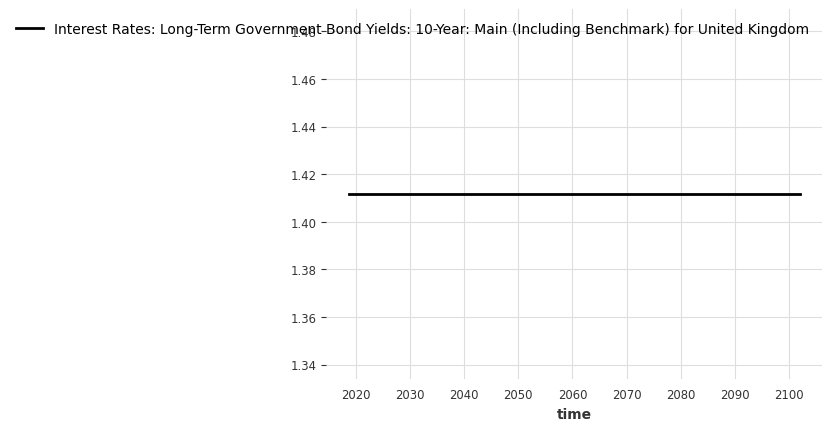

In [33]:
model_aarima.predict(1000).plot()
plt.show()

# Avaliação de modelos com backtest histórico

Nesta secção avaliamos 3 famílias de modelos relativamente à performance de previsão a diferentes horizontes, com retreino diário ao longo do tempo. As funções de backtest desenvolvidas com base nos _historical forecasts_ do pacote *darts* permitem várias configurações, como comparação de múltiplos modelos, múltiplos horizontes e múltiplas métricas.

In [34]:
from darts.models import NaiveSeasonal, Prophet, AutoETS, AutoARIMA

Utiliza-se um modelo baseline que simplesmente propaga no horizonte o valor real mais recente observado.

In [35]:
base_model = NaiveSeasonal(K=1)
base_model.model_name = "Baseline"

Utilizamos os modelos das famílias ETS e ARIMA com seleção automática de parâmetros por meio de ccritérios de informação, e Prophet, com inclusão dos feriados nacionais do Reino Unido.

In [36]:
default_aets = AutoETS()
default_aets.model_name = "AutoETS"
# default_aets.fit(train)

default_aarima = AutoARIMA()
default_aarima.model_name = "AutoARIMA"
# default_aarima.fit(train)

default_prophet = Prophet(country_holidays="GB", suppress_stdout_stderror=True)
default_prophet.model_name = "Prophet"
# default_prophet.fit(train)

default_models = [default_aets, default_aarima, default_prophet]

In [37]:
# Metricas a utilizar
metrics = [smape, r2_score]

Função principal de backtesting:

In [38]:
def backtest_models(
    series: TimeSeries, 
    models: list=default_models, 
    horizons: list=[1, 3, 7], 
    points_to_test: int=len(test), 
    verbose=True, retrain=True, baseline=base_model, metrics=metrics
):
    backtest_results = dict()
    # opcao de inclusao do modelo baseline de comparacao, incluido por defeito
    if baseline:
        models = [baseline, *models]
    # para cada horizonte de previsao, as previsoes de cada modelo sao avaliadas
    for horizon in sorted(horizons):
        print(f"Backtesting {horizon} {series.freq} horizon")
        backtests = []
        for model in models:
            if model.model_name == "Baseline":
                backtest = model.historical_forecasts(
                    series,
                    start=len(series) - points_to_test,
                    forecast_horizon=horizon,
                    retrain=True,  # modelo baseline obrigatoriamente retreinado
                    verbose=False,
                )
            else:
                print(f"Backtesting {model.model_name}")
                backtest = model.historical_forecasts(
                    series,
                    start=len(series) - points_to_test,
                    forecast_horizon=horizon,
                    verbose=verbose,
                    retrain=retrain,
                )
            backtests.append(backtest)
        backtest_results[horizon] = {
            model.model_name: (backtests[i], {metric.__name__: round(metric(series, backtests[i]), 3) for metric in metrics}) 
            for i, model in enumerate(models)
        }
    return backtest_results

Função de visualização de resultados de backtest:

In [39]:
def plot_backtest_results(
    series: TimeSeries, 
    backtest_results: dict, 
    points_to_test: int=len(test),
):
    for horizon, model in backtest_results.items():
        plt.figure(figsize=(12, 6))
        series.drop_before(int(len(series) - 1.5*points_to_test)).plot(label='data')
        for model_name, (backtest, metrics) in model.items():
            backtest.plot(lw=3, label=f'{model_name}, {metrics}')
        plt.title(f'Backtests with {horizon} {series.freq} forecast horizon')
        plt.legend()
        plt.show()

In [40]:
horizons = [1, 2, 3, 5, 7, 15, 30]

In [41]:
results = backtest_models(
    series, 
    horizons=horizons, 
    metrics=metrics, 
    points_to_test=len(test)
)

Backtesting 1 <MonthBegin> horizon
Backtesting AutoETS


historical forecasts:   0%|          | 0/80 [00:00<?, ?it/s]

Backtesting AutoARIMA


historical forecasts:   0%|          | 0/80 [00:00<?, ?it/s]

Backtesting Prophet


historical forecasts:   0%|          | 0/80 [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting AutoETS


historical forecasts:   0%|          | 0/79 [00:00<?, ?it/s]

Backtesting AutoARIMA


historical forecasts:   0%|          | 0/79 [00:00<?, ?it/s]

Backtesting Prophet


historical forecasts:   0%|          | 0/79 [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting AutoETS


historical forecasts:   0%|          | 0/78 [00:00<?, ?it/s]

Backtesting AutoARIMA


historical forecasts:   0%|          | 0/78 [00:00<?, ?it/s]

Backtesting Prophet


historical forecasts:   0%|          | 0/78 [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting AutoETS


historical forecasts:   0%|          | 0/76 [00:00<?, ?it/s]

Backtesting AutoARIMA


historical forecasts:   0%|          | 0/76 [00:00<?, ?it/s]

Backtesting Prophet


historical forecasts:   0%|          | 0/76 [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting AutoETS


historical forecasts:   0%|          | 0/74 [00:00<?, ?it/s]

Backtesting AutoARIMA


historical forecasts:   0%|          | 0/74 [00:00<?, ?it/s]

Backtesting Prophet


historical forecasts:   0%|          | 0/74 [00:00<?, ?it/s]

Backtesting 15 <MonthBegin> horizon
Backtesting AutoETS


historical forecasts:   0%|          | 0/66 [00:00<?, ?it/s]

Backtesting AutoARIMA


historical forecasts:   0%|          | 0/66 [00:00<?, ?it/s]

Backtesting Prophet


historical forecasts:   0%|          | 0/66 [00:00<?, ?it/s]

Backtesting 30 <MonthBegin> horizon
Backtesting AutoETS


historical forecasts:   0%|          | 0/51 [00:00<?, ?it/s]

Backtesting AutoARIMA


historical forecasts:   0%|          | 0/51 [00:00<?, ?it/s]

Backtesting Prophet


historical forecasts:   0%|          | 0/51 [00:00<?, ?it/s]

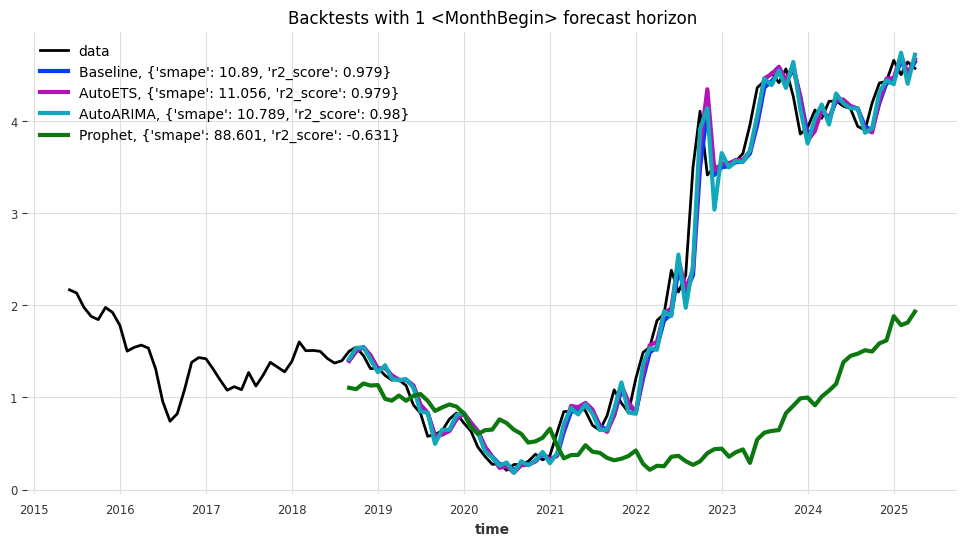

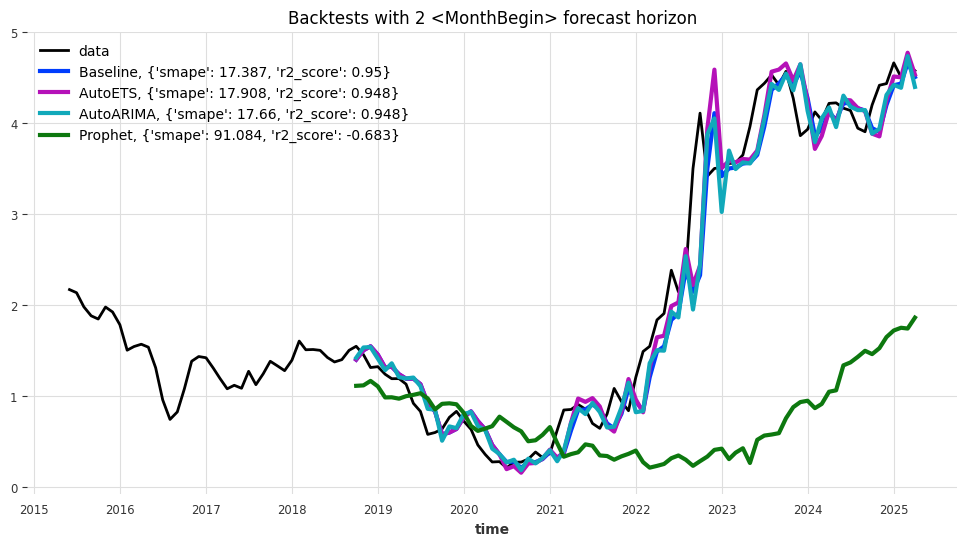

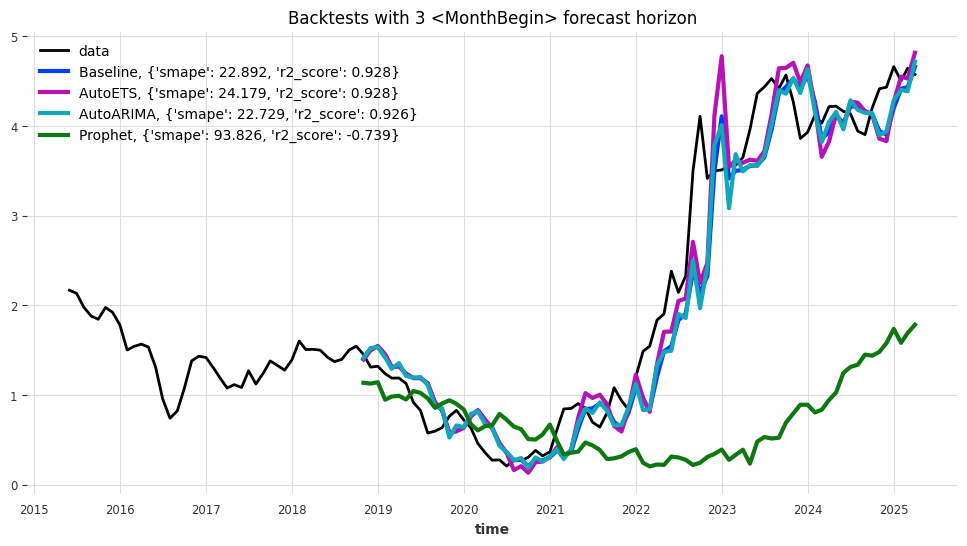

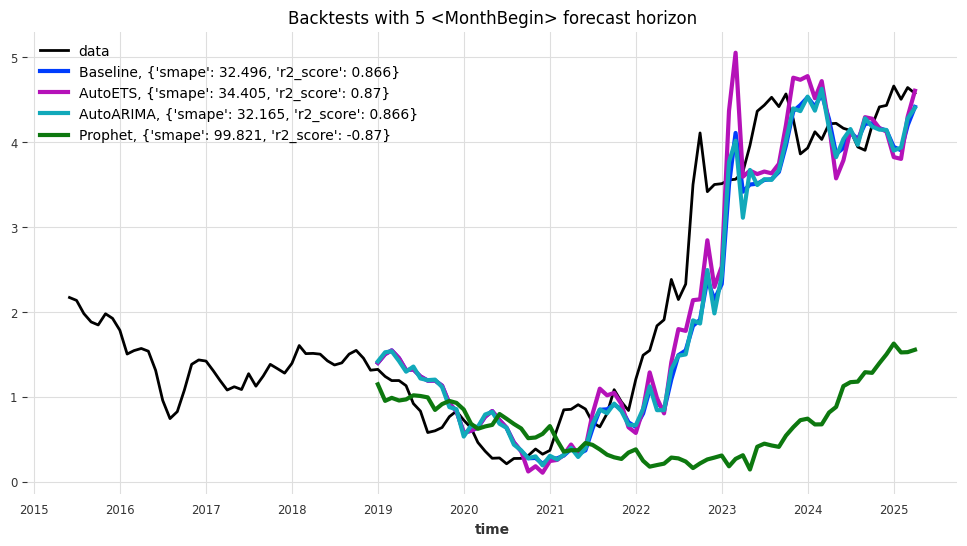

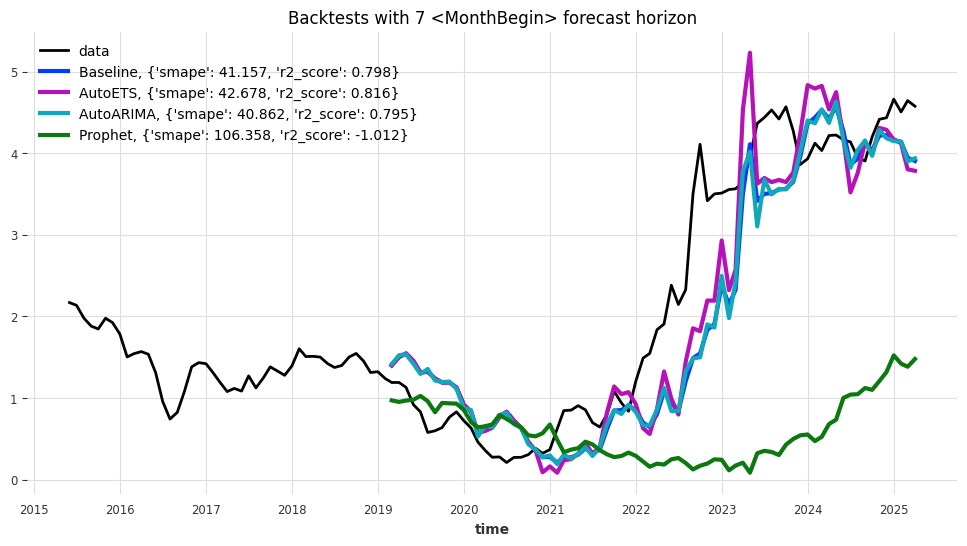

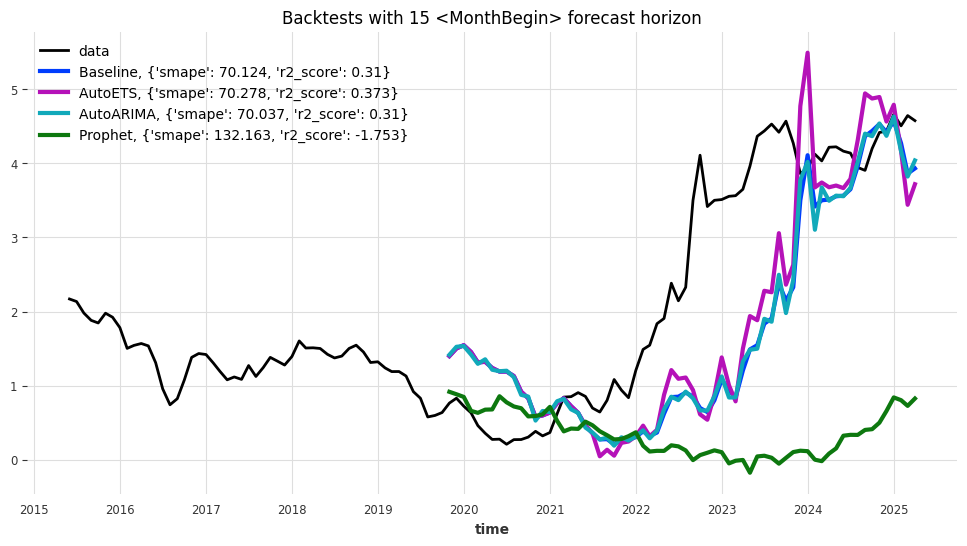

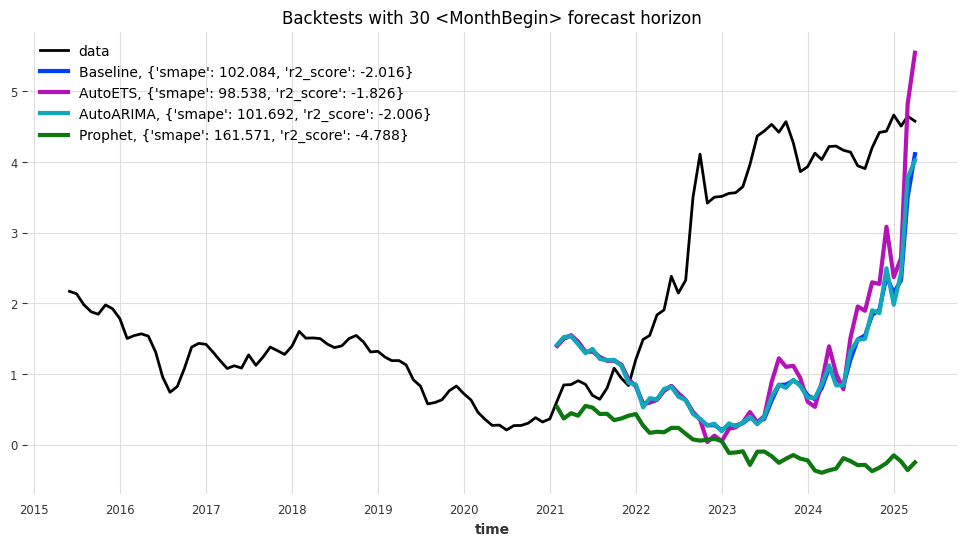

In [42]:
plot_backtest_results(series, results, points_to_test=len(test))

### Extra: Comparação de critérios de seleção de modelos ARIMA

Nesta secção avaliamos a performance em backtest de dois modelos treinados no conjunto de teste utilizando dois critérios de informação diferentes. Procuramos fornecer um exemplo real das vantagens de usar modelos com menos parâmetro numa simulação do uso real de previsão em timeseries providenciado por backtesting.

In [43]:
aarima_bic = AutoARIMA(trace=True, ic="bic")
aarima_bic = aarima_bic.fit(train)
aarima_bic.model_name = "AutoARIMA - BIC"

aarima_aicc = AutoARIMA(trace=True, ic="aicc")
aarima_aicc = aarima_aicc.fit(train)
aarima_aicc.model_name = "AutoARIMA - AICC"


ARIMA(2,1,2) with drift        :366.23875846274626

ARIMA(0,1,0) with drift        :441.5114017119695

ARIMA(1,1,0) with drift        :369.0406599164327

ARIMA(0,1,1) with drift        :354.2854032415081

ARIMA(0,1,0)                   :435.1601178269001

ARIMA(1,1,1) with drift        :360.55753405322747

ARIMA(0,1,2) with drift        :360.3756369902082

ARIMA(1,1,2) with drift        :363.9505147324274

ARIMA(0,1,1)                   :347.85326188975955

ARIMA(1,1,1)                   :354.1205804413995

ARIMA(0,1,2)                   :353.9361158017699

ARIMA(1,1,0)                   :362.5863778707603

ARIMA(1,1,2)                   :357.5091001065179
Now re-fitting the best model(s) without approximations...


ARIMA(0,1,1)                   :347.85326188975955

ARIMA(2,1,2) with drift        :339.0273067670547

ARIMA(0,1,0) with drift        :432.417830785491

ARIMA(1,1,0) with drift        :355.40892400494914

ARIMA(0,1,1) with drift        :340.6536673300246

ARIMA(0,1,0)     

Para utilizar a comparação dos modelos selecionados, realizamos backtest no conjunto de teste sem recorrer ao retreino diário.

In [44]:
results = backtest_models(
    series, 
    models=[aarima_bic, aarima_aicc], 
    retrain=False, 
    horizons=horizons,
    points_to_test=len(test)
)

Backtesting 1 <MonthBegin> horizon
Backtesting AutoARIMA - BIC


historical forecasts:   0%|          | 0/80 [00:00<?, ?it/s]

Backtesting AutoARIMA - AICC


historical forecasts:   0%|          | 0/80 [00:00<?, ?it/s]

Backtesting 2 <MonthBegin> horizon
Backtesting AutoARIMA - BIC


historical forecasts:   0%|          | 0/79 [00:00<?, ?it/s]

Backtesting AutoARIMA - AICC


historical forecasts:   0%|          | 0/79 [00:00<?, ?it/s]

Backtesting 3 <MonthBegin> horizon
Backtesting AutoARIMA - BIC


historical forecasts:   0%|          | 0/78 [00:00<?, ?it/s]

Backtesting AutoARIMA - AICC


historical forecasts:   0%|          | 0/78 [00:00<?, ?it/s]

Backtesting 5 <MonthBegin> horizon
Backtesting AutoARIMA - BIC


historical forecasts:   0%|          | 0/76 [00:00<?, ?it/s]

Backtesting AutoARIMA - AICC


historical forecasts:   0%|          | 0/76 [00:00<?, ?it/s]

Backtesting 7 <MonthBegin> horizon
Backtesting AutoARIMA - BIC


historical forecasts:   0%|          | 0/74 [00:00<?, ?it/s]

Backtesting AutoARIMA - AICC


historical forecasts:   0%|          | 0/74 [00:00<?, ?it/s]

Backtesting 15 <MonthBegin> horizon
Backtesting AutoARIMA - BIC


historical forecasts:   0%|          | 0/66 [00:00<?, ?it/s]

Backtesting AutoARIMA - AICC


historical forecasts:   0%|          | 0/66 [00:00<?, ?it/s]

Backtesting 30 <MonthBegin> horizon
Backtesting AutoARIMA - BIC


historical forecasts:   0%|          | 0/51 [00:00<?, ?it/s]

Backtesting AutoARIMA - AICC


historical forecasts:   0%|          | 0/51 [00:00<?, ?it/s]

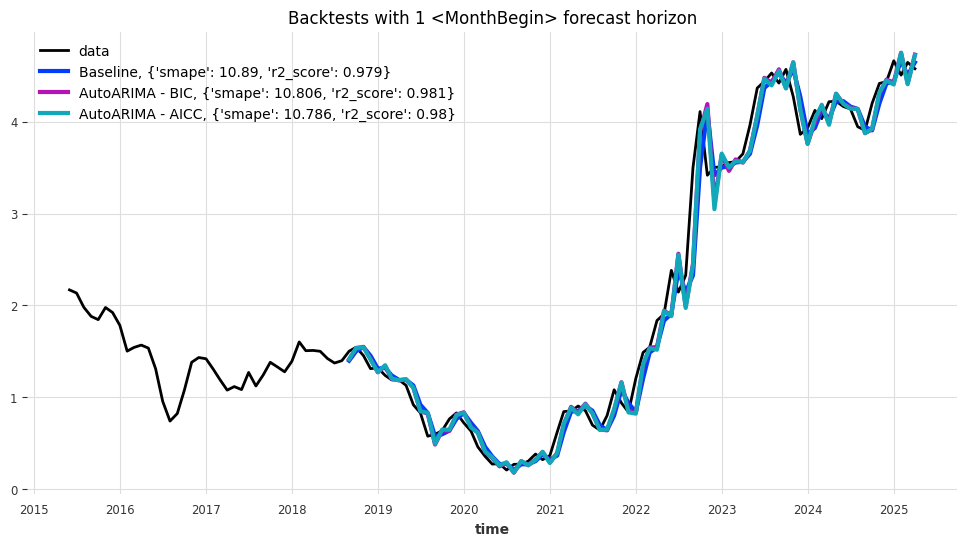

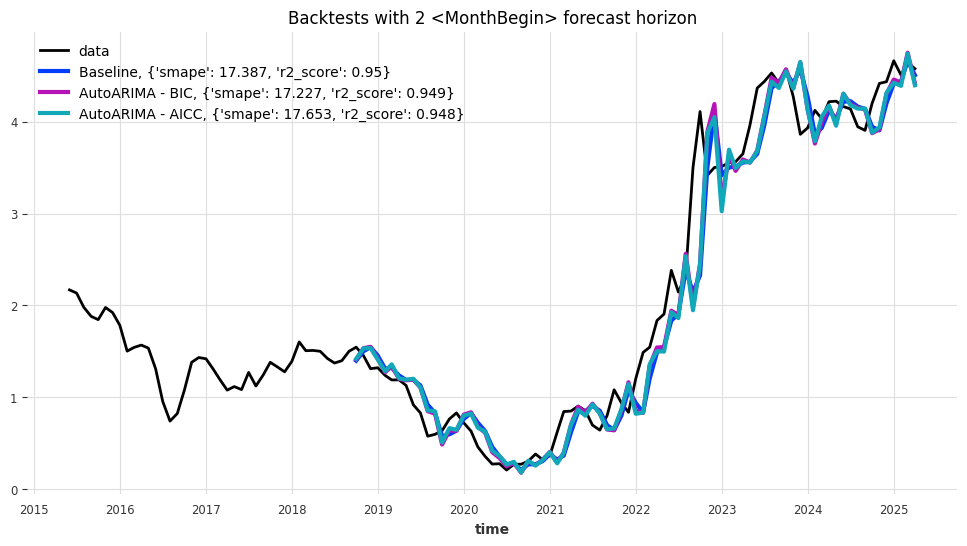

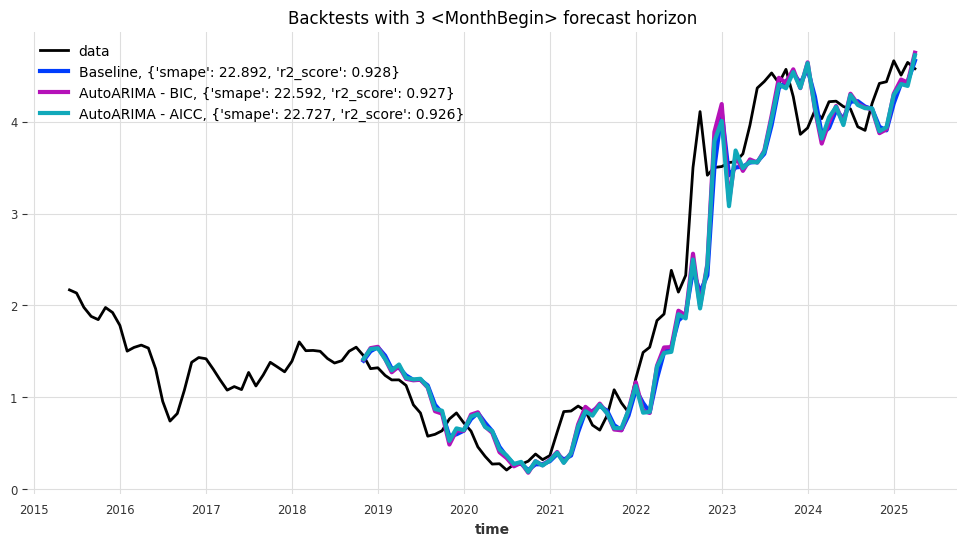

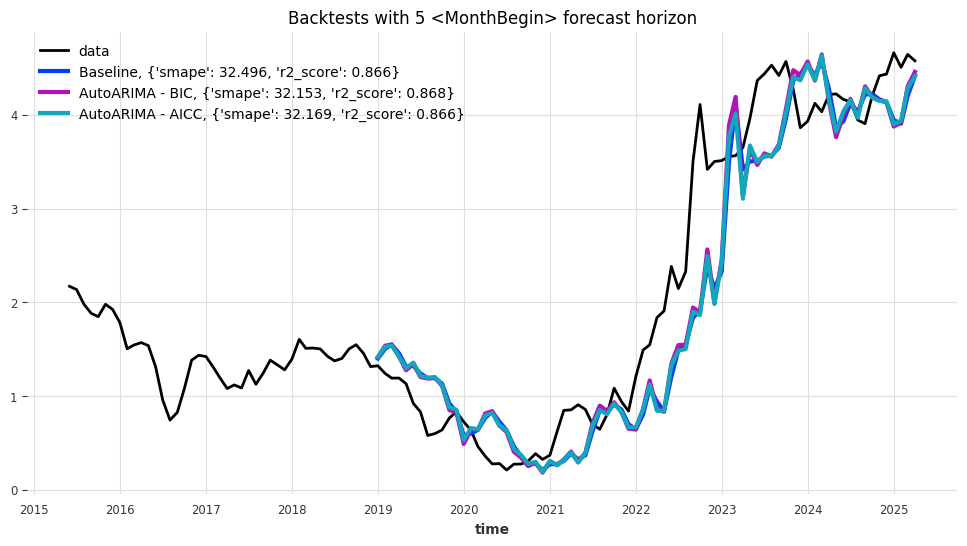

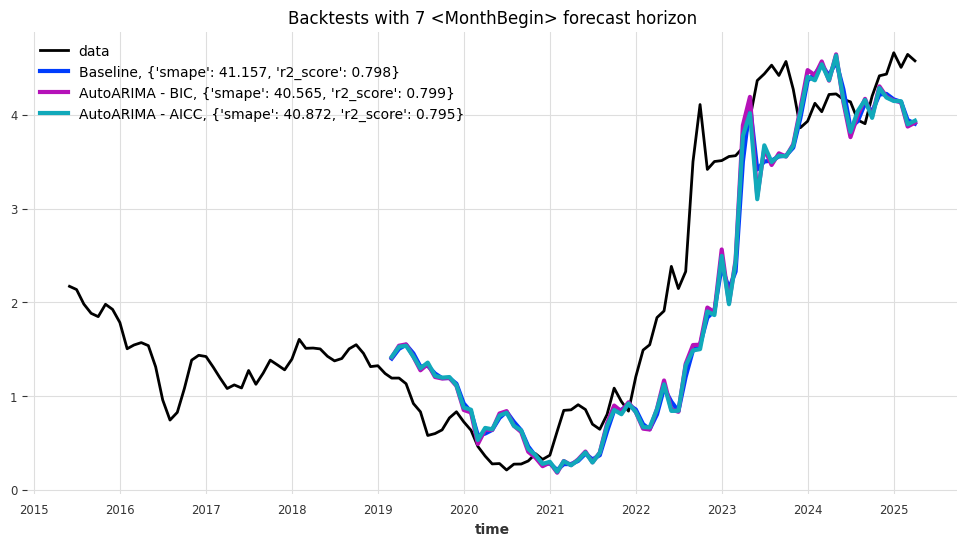

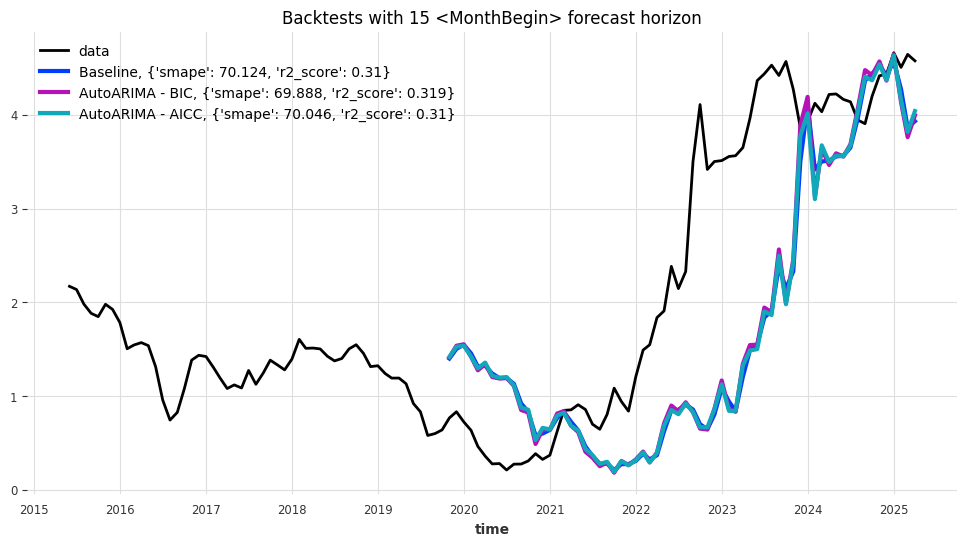

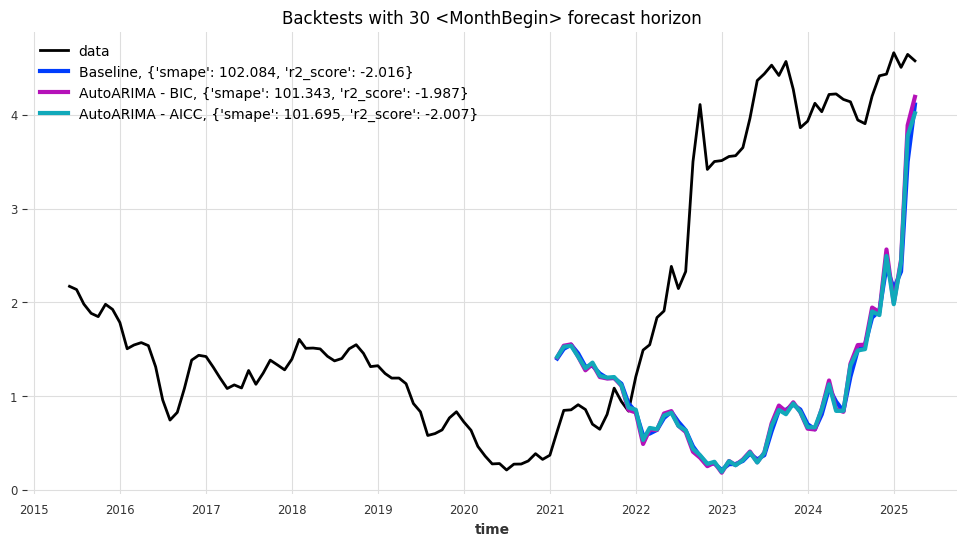

In [45]:
plot_backtest_results(
    series, 
    results,
    points_to_test=len(test),
)

# Comparação entre critérios de informação e optimização bayesiana para seleção de modelos

In [46]:
horizon = [7]

In [47]:
from sklearn.preprocessing import MaxAbsScaler
from darts.dataprocessing.transformers import Scaler

In [48]:
scaler = MaxAbsScaler()
transformer = Scaler(scaler)

In [49]:
model_modes = {
    "none": ModelMode.NONE,
    "additive": ModelMode.ADDITIVE,
    "multiplicative": ModelMode.MULTIPLICATIVE,
}
seasonal_modes = {
    "none": SeasonalityMode.NONE,
    "additive": SeasonalityMode.ADDITIVE,
    "multiplicative": SeasonalityMode.MULTIPLICATIVE,
}

In [50]:
from darts.models import StatsForecastModel

In [51]:
series_scaled = transformer.fit_transform(series)

In [52]:
model_list = [
    "AutoETS",
    "AutoARIMA",
    "Prophet",
]
model_family = model_list[0]

In [53]:
from darts.ad import KMeansScorer

scorer = KMeansScorer(k=2, window=5)
scorer.fit(train)
anom_score = scorer.score(test)

In [54]:
from darts.ad import QuantileDetector

detector = QuantileDetector(high_quantile=0.99)
detector.fit(scorer.score(train))
binary_anom = detector.detect(anom_score)

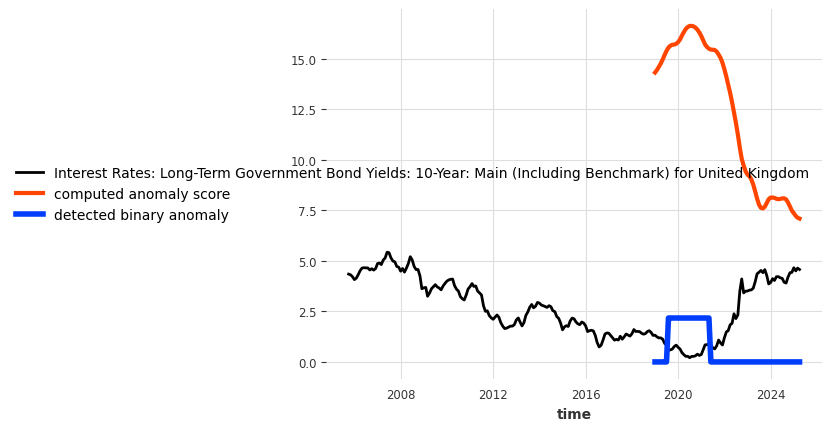

In [55]:
series.drop_before(visualizing).plot()
(anom_score + 1.5 * max(series.drop_before(visualizing))).plot(label="computed anomaly score", c="orangered", lw=3)
(binary_anom * .5 * max(series.drop_before(visualizing))).plot(label="detected binary anomaly", lw=4)
plt.show()